In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/MLDL_repo/GTA5.zip'
extract_path = '/content/dataset'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/MLDL_repo/Cityscapes.zip'
extract_path = '/content/dataset'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MLDL_repo/step5_unet')

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.1, 1.0), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.0, p=0.5),
    A.Resize(720, 1280),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

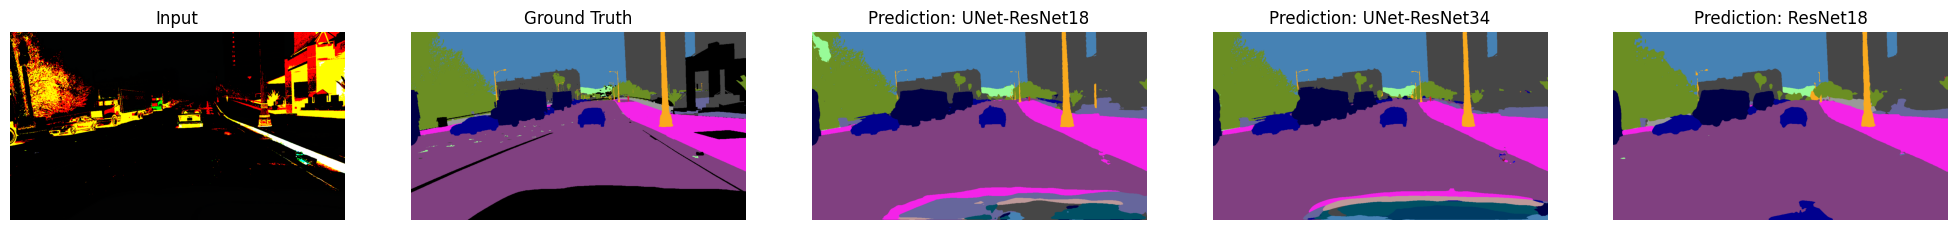

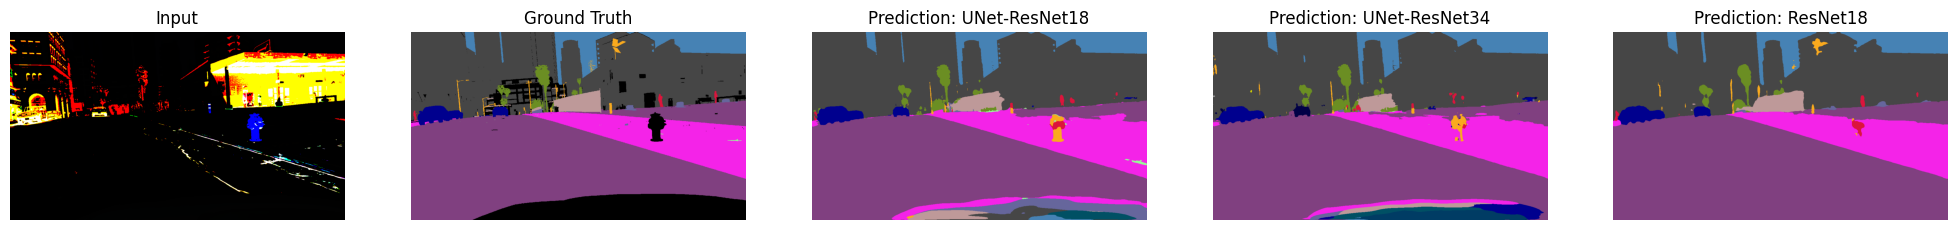

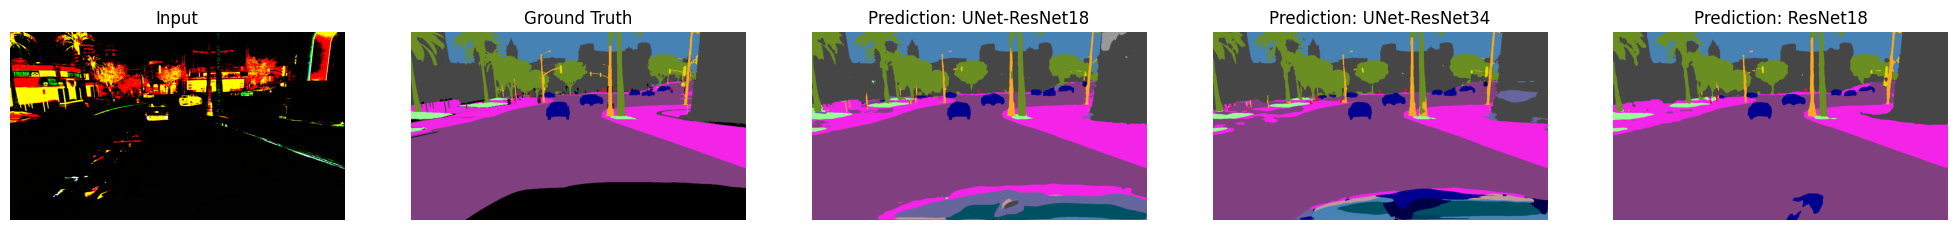

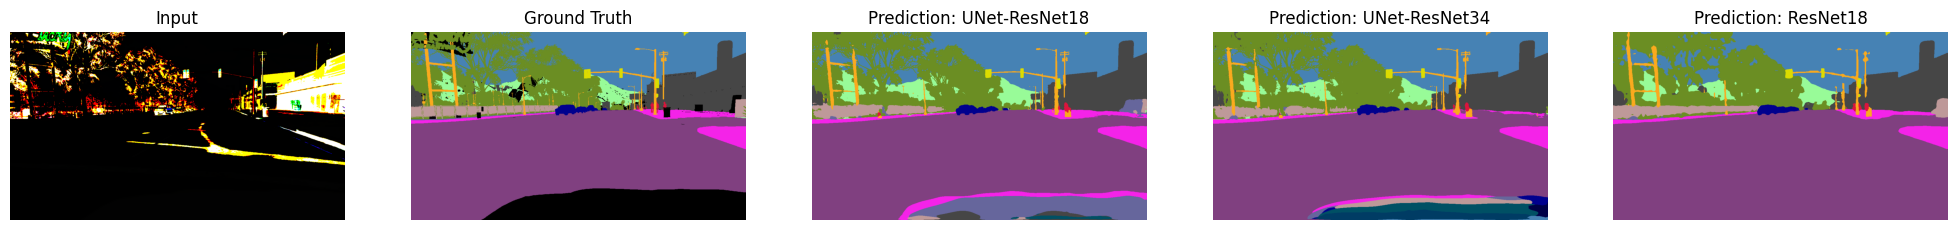

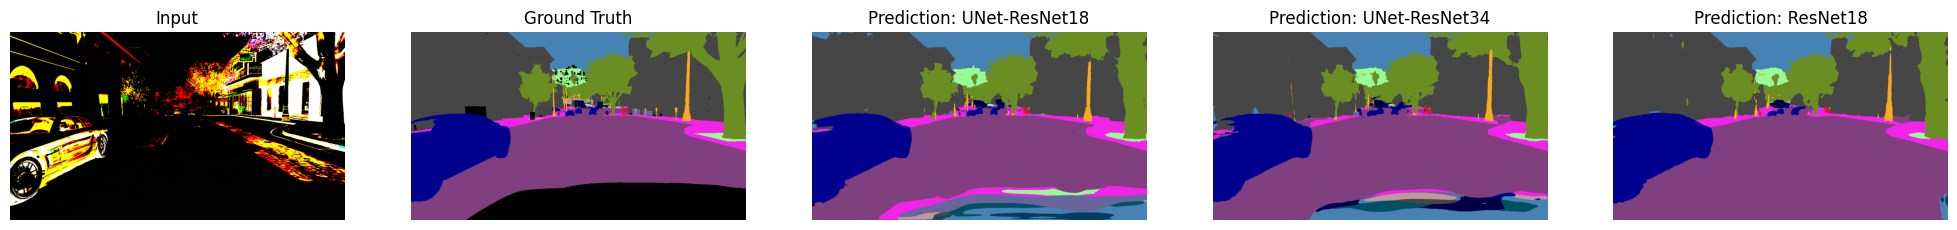

Quantitative Evaluation:
UNet-ResNet18 -> Loss: 0.1267 | Acc: 0.9592 | mIoU: 0.4634 | Dice: 0.7088
UNet-ResNet34 -> Loss: 0.1498 | Acc: 0.9542 | mIoU: 0.4465 | Dice: 0.6719
ResNet18 -> Loss: 0.1238 | Acc: 0.9616 | mIoU: 0.4939 | Dice: 0.7729


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet18, resnet34
from train import evaluate
from model.resnet_unet import SResUnet
from model.ResNet18 import ResNet18
from dataset_custom.gta5_aug import GTA5
from dataset_custom.labels import GTA5Labels_TaskCV2017


def decode_segmap(label_tensor, label_colors, ignore_index=255):
    label_np = label_tensor.cpu().numpy()
    h, w = label_np.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)

    id2color = {lab.ID: lab.color for lab in label_colors.list_}
    for id_, color in id2color.items():
        mask = label_np == id_
        color_img[mask] = color
    color_img[label_np == ignore_index] = (0, 0, 0)
    return color_img



def compare_models_predictions(models_dict, dataloader, device, label_colors, num_images=5, denorm=None):
    shown = 0
    for imgs, gt in dataloader:
        imgs = imgs.to(device)
        gt = gt.to(device)

        preds = {}
        with torch.no_grad():
            for name, model in models_dict.items():
                with torch.autocast(device.type if device.type != 'mps' else 'cpu'):
                    logits = model(imgs)
                    if isinstance(logits, tuple):
                        logits = logits[0]
                    preds[name] = torch.argmax(logits, dim=1)

        for i in range(imgs.size(0)):
            img_np = imgs[i].cpu()
            if denorm is not None:
                img_np = denorm(img_np)
            else:
                img_np = img_np.permute(1, 2, 0).numpy()
                if img_np.max() <= 1:
                    img_np = (img_np * 255).astype(np.uint8)
                else:
                    img_np = img_np.astype(np.uint8)

            gt_color = decode_segmap(gt[i], label_colors)

            n_models = len(models_dict)
            plt.figure(figsize=(5 * (2 + n_models), 5))
            plt.subplot(1, 2 + n_models, 1)
            plt.title("Input")
            plt.imshow(img_np)
            plt.axis('off')

            plt.subplot(1, 2 + n_models, 2)
            plt.title("Ground Truth")
            plt.imshow(gt_color)
            plt.axis('off')

            for idx, (name, pred_tensor) in enumerate(preds.items(), start=3):
                pred_color = decode_segmap(pred_tensor[i], label_colors)
                plt.subplot(1, 2 + n_models, idx)
                plt.title(f"Prediction: {name}")
                plt.imshow(pred_color)
                plt.axis('off')

            plt.show()
            shown += 1
            if shown >= num_images:
                return


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

paths = {
    'UNet-ResNet18': '/content/drive/MyDrive/MLDL_repo/step5_unet/unet_resnet18/unet_resnet18_final.pht',
    'UNet-ResNet34': '/content/drive/MyDrive/MLDL_repo/step5_unet/unet_resnet34/unet_resnet34_final.pht',
    'ResNet18':      '/content/drive/MyDrive/MLDL_repo/step5_unet/resnet18/resnet18_final.pht',
}

models = {}
for name, path in paths.items():
    if 'resnet34' in name.lower():
        encoder = resnet34
    else:
        encoder = resnet18

    if 'unet' in name.lower():
        model = SResUnet(encoder, pretrained=True, out_channels=19) # out_channel = num_classes
    else:
        model = ResNet18(num_classes=19, pretrained=True)  # <-- deve essere definito a parte
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    models[name] = model


# Dataset & Dataloader
data_root = '/content/dataset/GTA5'
dataset = GTA5(root=data_root, transform=transform)
val_len = int(len(dataset) * 0.3)
_, val_set = torch.utils.data.random_split(dataset, [len(dataset) - val_len, val_len])

val_loader = DataLoader(val_set, batch_size=2, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)


gta5_labels = GTA5Labels_TaskCV2017
compare_models_predictions(models, val_loader, device, gta5_labels, num_images=5)

criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
num_classes = 19

print("Quantitative Evaluation:")
for name, model in models.items():
    loss, acc, miou, dice = evaluate(model, val_loader, criterion, device, num_classes)
    print(f"{name} -> Loss: {loss:.4f} | Acc: {acc:.4f} | mIoU: {miou:.4f} | Dice: {dice:.4f}")
